## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import pandas_ta as ta
import datetime
#from fastai.tabular.core import add_datepart
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [2]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data_2y.csv')

In [3]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

## 2. Create SMA (10, 20, 60 days)

In [4]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

## 3. Create RSI 14

In [5]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

In [6]:
# concatenate all 4 dataframse
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)

In [7]:
test_plot_df = sorted_df[['ALB_ZBRA', 'ALB_ZBRA_SMA_10', 'ALB_ZBRA_SMA_20', 'ALB_ZBRA_SMA_60']]

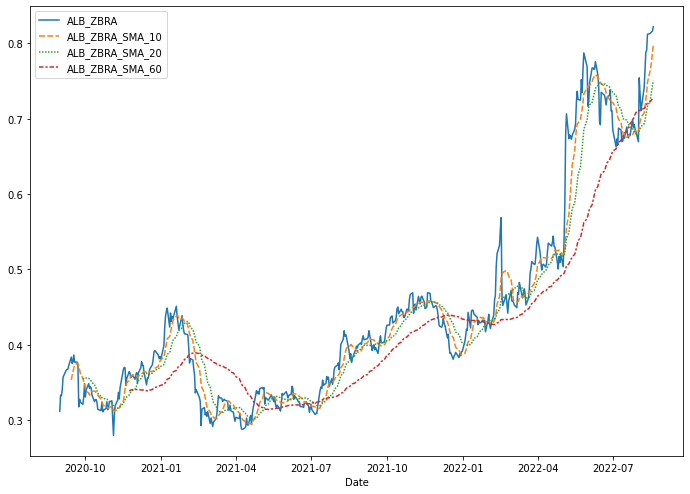

In [8]:
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=test_plot_df.iloc[:, :5]);

## 4. Clean dataframe

In [9]:
sorted_df = sorted_df.fillna(sorted_df.median())

## 5. Extract features with prophet

In [10]:
# full df
sorted_df.head()

,ALB_ZBRA,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,DE_BXP,DE_BXP_RSI_14,DE_BXP_SMA_10,DE_BXP_SMA_20,DE_BXP_SMA_60,...,PEG_O,PEG_O_RSI_14,PEG_O_SMA_10,PEG_O_SMA_20,PEG_O_SMA_60,SO_NLOK,SO_NLOK_RSI_14,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,0.311845,53.506606,0.401902,0.40318,0.392237,2.548054,53.376443,3.24198,3.235732,3.211952,...,0.882281,49.875527,0.961826,0.966244,0.968382,2.136432,52.240503,2.629768,2.620719,2.571855
2020-09-01,0.332974,53.506606,0.401902,0.40318,0.392237,2.687319,53.376443,3.24198,3.235732,3.211952,...,0.855546,49.875527,0.961826,0.966244,0.968382,2.094566,52.240503,2.629768,2.620719,2.571855
2020-09-02,0.332368,53.506606,0.401902,0.40318,0.392237,2.629334,53.376443,3.24198,3.235732,3.211952,...,0.872526,49.875527,0.961826,0.966244,0.968382,2.125291,52.240503,2.629768,2.620719,2.571855
2020-09-03,0.339772,53.506606,0.401902,0.40318,0.392237,2.534974,53.376443,3.24198,3.235732,3.211952,...,0.848504,49.875527,0.961826,0.966244,0.968382,2.210971,52.240503,2.629768,2.620719,2.571855
2020-09-04,0.356920,53.506606,0.401902,0.40318,0.392237,2.536138,53.376443,3.24198,3.235732,3.211952,...,0.854765,49.875527,0.961826,0.966244,0.968382,2.152835,52.240503,2.629768,2.620719,2.571855


In [11]:
# for testing, we just extract one ratio
#one_ratio_df = sorted_df.iloc[:, :5]
sorted_df.iloc[:, :5]

,ALB_ZBRA,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60
Date,,,,,
2020-08-31,0.311845,53.506606,0.401902,0.403180,0.392237
2020-09-01,0.332974,53.506606,0.401902,0.403180,0.392237
2020-09-02,0.332368,53.506606,0.401902,0.403180,0.392237
2020-09-03,0.339772,53.506606,0.401902,0.403180,0.392237
2020-09-04,0.356920,53.506606,0.401902,0.403180,0.392237
...,...,...,...,...,...
2022-08-15,0.813028,70.504616,0.762595,0.722713,0.722300
2022-08-16,0.814154,70.669445,0.768577,0.729514,0.723594
2022-08-17,0.815450,70.871029,0.776736,0.736559,0.725092


In [12]:
def prophet_features(df, horizon=30):
    temp_df = df.reset_index()
    ratio_name = df.columns[0]
    temp_df = temp_df[['Date', ratio_name]]
    temp_df.rename(columns={'Date': 'ds', ratio_name: 'y'}, inplace=True)
    
    # take last week of the dataset for validation
    train_set, test_set = temp_df.iloc[:-horizon,:], temp_df.iloc[-horizon:,:]
    
    # define prophet model
    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )
    # train prophet model
    m.fit(train_set)
    
    # extract features from data using prophet to predict train set
    predictions_train = m.predict(train_set.drop('y', axis=1))
    # extract features from data using prophet to predict test set
    predictions_test = m.predict(test_set.drop('y', axis=1))
    # merge train and test predictions
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions

In [13]:
#proph_features = prophet_features(one_ratio_df)

In [14]:
#proph_features.head(2)

⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️

## 6. Train XGBoost model

In [15]:
def train_xgb_with_prophet_features(df, horizon=30, lags=[1, 2, 3, 4, 5]):
    # create a dataframe with all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    # merge the Prophet features df with the first df
    df = pd.merge(df, new_prophet_features, left_on=['Date'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # create some lag variables using Prophet predictions (yhat column)
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    ratio_name = df.columns[0]
    X = df.drop(ratio_name, axis=1)
    y = df[ratio_name]
    
    # take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # define XGBoost model, train it and make predictions
    xgb_model = XGBRegressor(n_estimators=1000,
                             learning_rate=0.01,
                             max_depth=6,
                             subsample=0.6,
                             colsample_bytree=0.7,
                             random_state=42,
                             eval_metric='mape'
                             )
    #model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    predictions = xgb_model.predict(X_test)
    
    #  compute MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3) 
    # compute MAPE
    y_true, y_pred = np.array(y_test), np.array(predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    # plot reality vs prediction for the last 95 days of the dataset
    #fig = plt.figure(figsize=(16,6))
    #plt.title(f'{ratio_name}: Actual vs Prediction - MAPE {round(mape, 2)} & MAE {mae}', fontsize=20)
    #plt.plot(y_test, color='mediumblue')
    #plt.plot(pd.Series(predictions, index=y_test.index), color='darkviolet')
    #plt.xlabel('Date', fontsize=16)
    #plt.ylabel('Ratio', fontsize=16)
    #plt.legend(labels=['Actual', 'Prediction'], fontsize=16)
    #plt.grid()
    #plt.show()
    
    mape_dict = {}
    mape_dict[ratio_name] = mape
    return [mape_dict, predictions]

## 7. Create model for each ratio

In [16]:
# get number of ratios
num_of_ratios = int(sorted_df.shape[1] / 5)

# create column pointers
col_l = 0
col_r = 5

# create dict for mape
mape_list = []
preds = []

for i in range(0, num_of_ratios, 1):
    ratio_df = sorted_df.iloc[:, col_l:col_r]
    returned_mape_dict, returned_preds = train_xgb_with_prophet_features(ratio_df)
    mape_list.append(returned_mape_dict)
    preds.append(returned_preds)
    col_l += 5
    col_r += 5

Initial log joint probability = -6.55617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1114.51    0.00718148       143.628           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1122.31   0.000672452       305.054      0.4523      0.4523      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1127.72    0.00180575       93.1789      0.8639      0.8639      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1128.89    0.00305199       116.051       0.818       0.818      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     416       1129.07    0.00112853       210.468    1.37e-05       0.001      600  LS failed, Hessian reset 
     487       1129.23   7.86082e-05    

In [17]:
# convert list of dicts to dict
mape_dict = {k:v for element in mape_list for k,v in element.items()}

In [18]:
ratio_df

,Date,SO_NLOK,SO_NLOK_RSI_14,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60
0,2020-08-31,2.136432,52.240503,2.629768,2.620719,2.571855
1,2020-09-01,2.094566,52.240503,2.629768,2.620719,2.571855
2,2020-09-02,2.125291,52.240503,2.629768,2.620719,2.571855
3,2020-09-03,2.210971,52.240503,2.629768,2.620719,2.571855
4,2020-09-04,2.152835,52.240503,2.629768,2.620719,2.571855
...,...,...,...,...,...,...
492,2022-08-15,3.277218,63.210855,3.136534,3.047101,3.070884
493,2022-08-16,3.283272,63.535067,3.159514,3.066469,3.074085
494,2022-08-17,3.347435,66.867644,3.206335,3.090913,3.079466
495,2022-08-18,3.371537,68.048883,3.251391,3.118340,3.085444


In [19]:
print(f'The average MAPE of all {len(mape_dict)} ratios is: {round(sum(mape_dict.values()) / len(mape_dict), 2)}%')

The average MAPE of all 7 ratios is: 2.86%


## 8. Create prediction dataframe

In [20]:
# select every 5th column to get the ratio name
preds_cols = sorted_df.columns[::5]

In [21]:
preds_df = pd.DataFrame()
i = 0

for pred in preds:
    preds_df[preds_cols[i]] = pred
    i += 1

In [22]:
check_df = sorted_df.reset_index()

In [23]:
actual_start_date = (check_df['Date'].iloc[-1] +
                     datetime.timedelta(days=1)).strftime("%Y-%m-%d")
actual_end_date = (check_df['Date'].iloc[-1] +
                   datetime.timedelta(days=30)).strftime("%Y-%m-%d")

In [24]:
preds_df['Date'] = pd.date_range(actual_start_date, actual_end_date)
first_column = preds_df.pop('Date')
preds_df.insert(0, 'Date', first_column)

In [55]:
preds_df.head(2)

,Date,ALB_ZBRA,DE_BXP,NRG_CPRT,NRG_STE,NRG_XRAY,PEG_O,SO_NLOK
0,2022-08-20,0.680070,3.416140,0.330774,0.177161,1.058542,0.904152,3.097630
1,2022-08-21,0.672388,3.380754,0.332363,0.179013,1.057387,0.900822,3.093496


## 9. Recommend best 5 ratios

In [26]:
# sort from best to worst
bst_list = sorted(mape_dict.items(), key=lambda item: item[1])

In [27]:
best_five = dict(bst_list)
best_five = {k: best_five[k] for k in list(best_five)[:5]}
for k in best_five:
    print(k)

SO_NLOK
NRG_XRAY
NRG_STE
PEG_O
DE_BXP


## 10. Compute average true range (ATR)

In [28]:
# once a model is selected based on the lowest mape, we can download open, high, low prices
# convert best 5 to list
best_list = list(best_five.keys())
# get the 5 best ratios from the original dataset
df.set_index('Date', inplace=True)
best_atr_df = df[[c for c in df.columns if c in best_list]]

In [29]:
i = 0
length = best_atr_df.shape[1]
long_list = []
short_list = []

while i < length:
    ratio = best_atr_df.columns.str.split('_').tolist()[i]
    # get the long prices (numerator) for a defined period first
    numerator = ratio[0]
    long = yf.Ticker(numerator).history(period="1mo").reset_index()
    high_low_long = long['High'] - long['Low']
    high_close_long = np.abs(long['High'] - long['Close'].shift())
    low_close_long = np.abs(long['Low'] - long['Close'].shift())
    ranges_long = pd.concat([high_low_long, high_close_long, low_close_long], axis=1)
    true_range_long = np.max(ranges_long, axis=1)
    long[f'{numerator}'] = true_range_long.rolling(14).sum()/14
    long_list.append(long)
    
    # get the short prices (denominator) for a defined period second
    denominator = ratio[1]
    short = yf.Ticker(denominator).history(period="1mo").reset_index()
    high_low_short = short['High'] - short['Low']
    high_close_short = np.abs(short['High'] - short['Close'].shift())
    low_close_short = np.abs(short['Low'] - short['Close'].shift())
    ranges_short = pd.concat([high_low_short, high_close_short, low_close_short], axis=1)
    true_range_short = np.max(ranges_short, axis=1)
    short[f'{denominator}'] = true_range_short.rolling(14).sum()/14
    short_list.append(short)
    
    i += 1

In [30]:
long_df = []
short_df = []

# get list of last columns of long and short ATRs
for long in long_list:
    long_df.append(pd.DataFrame(long[long.columns[-1]]))

for short in short_list:
    short_df.append(pd.DataFrame(short[short.columns[-1]]))   

In [31]:
# generate list of best ratios as tuples
long_short = list(zip(long_df, short_df))

In [32]:
# loop to combine
final_conc_df = pd.DataFrame()
for i in range(0, len(long_short)):
    conc_df = pd.concat([pd.DataFrame(long_short[i][0]), pd.DataFrame(long_short[i][1])], axis=1)
    final_conc_df = pd.concat([final_conc_df, conc_df], axis=1)

In [33]:
# add back 'Date' columns
final_conc_df = pd.concat([final_conc_df, short_list[0]['Date']], axis=1)

In [34]:
# drop NANs
final_conc_df.dropna(how='any', axis=0, inplace=True)
# set index to 'Date' column
final_conc_df.set_index('Date', inplace=True)

In [35]:
# compute ATR for long/short ratios
final_atr_df = pd.DataFrame()
for i in range(0, final_conc_df.shape[1], 2):
    final_atr_df[f'{final_conc_df.columns[i]}_{final_conc_df.columns[i+1]}'] = \
                  final_conc_df.iloc[:, i] / final_conc_df.iloc[:, i+1]

In [36]:
# collect all ATRs in a dict
atr_dict = {}
for col in final_atr_df:
    atr_dict[col] = round(final_atr_df[col].mean(), 3)

In [37]:
atr_dict

{'DE_BXP': 5.542,
 'NRG_STE': 0.2,
 'NRG_XRAY': 0.954,
 'SO_NLOK': 2.496,
 'PEG_O': 1.164}

## 11. Empirical information about the best ratios

In [38]:
# get best 5 ratios 
best_ratios = list(atr_dict.keys())
lst_mth_df = df[best_ratios][-20:]
lst_three_mth_df = df[best_ratios][-60:]

In [39]:
pl_one_dict = {}
pl_three_dict = {}
ptf_value = 10000

# calcualte change for 20 trading days
for col in lst_mth_df.columns:
    delta_one = lst_mth_df[col][19] / lst_mth_df[col][0]
    pl_one_dict[col] = round(ptf_value * delta_one, 2)
    
# calcualte change for 60 trading days
for col in lst_mth_df.columns:
    delta_three = lst_three_mth_df[col][59] / lst_three_mth_df[col][0]
    pl_three_dict[col] = round(ptf_value * delta_three, 2)

In [40]:
pl_one_dict

{'DE_BXP': 11818.48,
 'NRG_STE': 12529.68,
 'NRG_XRAY': 12049.57,
 'SO_NLOK': 11644.49,
 'PEG_O': 11193.4}

## 12. Compute price target and stop/loss based on ATR

In [41]:
atr_df = pd.DataFrame(atr_dict.items(), columns=['ratio', 'ATR'])

In [42]:
atr_df

,ratio,ATR
0,DE_BXP,5.542
1,NRG_STE,0.200
2,NRG_XRAY,0.954
3,SO_NLOK,2.496
4,PEG_O,1.164


In [43]:
#get the closing price of Friday
friday_close = pd.Series(dtype='float64')

for i in range(0, len(atr_df)):
    friday_close = friday_close.append(pd.Series(sorted_df[atr_df.ratio[i]].iloc[-1]))

In [44]:
friday_close = friday_close.rename('friday_close')
index_list = list(range(0, len(friday_close)))
friday_close.index = index_list

In [45]:
atr_df = pd.concat([atr_df, friday_close], axis=1)

In [46]:
# add target price columns
atr_df['target'] = atr_df['ATR'] + atr_df['friday_close']

In [47]:
# add stop/loss price column
atr_df['stop_loss'] = atr_df['friday_close'] - (1/3 * atr_df['ATR'])

In [48]:
atr_df

,ratio,ATR,friday_close,target,stop_loss
0,DE_BXP,5.542,4.280950,9.822950,2.433616
1,NRG_STE,0.200,0.204631,0.404631,0.137964
2,NRG_XRAY,0.954,1.200391,2.154391,0.882391
3,SO_NLOK,2.496,3.405268,5.901268,2.573268
4,PEG_O,1.164,0.951858,2.115858,0.563858


## 13. Compare MAPEs

In [49]:
arima_mape = pd.read_csv('../../long_short_local/raw_data/lstm_mape.csv', index_col=0)

In [50]:
arima_mape

,ratio,MAPE
0,ALB_ZBRA,0.146079
1,NRG_CPRT,0.254088
2,DE_BXP,0.060083
3,NRG_STE,0.085058
4,NRG_XRAY,0.235405
5,SO_NLOK,0.099380
6,PEG_O,0.055687


In [51]:
xgb_reg_mape = pd.DataFrame(mape_dict.items(), columns=['ratio', 'MAPE'])

In [52]:
xgb_reg_mape

,ratio,MAPE
0,ALB_ZBRA,3.017382
1,DE_BXP,2.994510
2,NRG_CPRT,5.248583
3,NRG_STE,2.422961
4,NRG_XRAY,2.130340
5,PEG_O,2.685984
6,SO_NLOK,1.531067


In [53]:
best_mape = determine_best_model(arima_mape, xgb_reg_mape)

NameError: name 'determine_best_model' is not defined

In [ ]:
print(f'The best model (lowest MAPE) is: {best_mape[0]} with a value of {best_mape[1]}.')

In [ ]:
# in a function...
def determine_best_model(lstm_mape, arima_mape, cnn_mape, xgb_reg_mape):
    # list of model names to print
    model_names = ['LSTM', 'ARIMA', 'CNN', 'Prophet/XGBoost']
    mape_list = [lstm_mape, arima_mape, cnn_mape, xgb_reg_mape]
    model_dict = {}

    # sort the MAPE from best (lowest) to worst (highest) and get the 5 best; round result to 4 digits
    for i in range(0, len(mape_list)):
        model_dict[model_names[i]] = round(mape_list[i].sort_values('MAPE').iloc[0:5]['MAPE'].mean(), 4)

    best_mape =  min(model_dict.items(), key=lambda x: x[1])
    return best_mape